# Title: Block VQE with Runtime

In this file we will generate the blocks from the Hamiltoniain and run a previously saved runtime program.  

# Generating the blocks

For now I will generate the blocks from a matrix representation of the Hamiltonian.  This can be optimized later on using binary numbers and masks.  

We will explore this Hamiltonian:
$$ 
    H =  \sum_{i} \left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1} + z Z_{i} Z_{i+1}\right) 
$$
breaking it up into two piecies, one which will be solved classically and the other which will be solved via VQE.

\begin{equation}
\begin{split}
H_{c,c'}=& T_{c,c'} + \delta_{cc'}\sum_{i=0}^{N_q} \left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1}  + z Z_{i} Z_{i+1}\right) 
\\
&+ \left(B^{1x}_{c,c'}X_{0} + B^{1y}_{c,c'} Y_{0} + B^{1z}_{c,c'} Z_{0} \right)
\end{split}
\end{equation}
Notice that I have shifted the chaing so that the quantum part now starts at $i=0$.  The classical part contains the following paramters
\begin{equation}
\begin{split}
& T_{c,c'} =  <c'|\sum_{i=0}^{N_c-2}\left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1} + z Z_{i} Z_{i+1}\right)|c> 
\\
& B1^x_{c,c'} =  x<c'|X_{N_c-1}|c>
\\
&B1^y_{c,c'} = y<c'|Y_{N_c-1}|c> 
\\
&B1^z_{c,c'} = z<c'|Y_{N_c-1}|c> 
\end{split}
\end{equation}

In [1]:
import qiskit.quantum_info as qi

def X(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'X'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Y(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'Y'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Z(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'Z'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

In [2]:
# A function to print the state given the numerical represenations
def bi(num,N):
    bi = bin(num)
    out = []
    Sdiff = N - len(bi) + 2
    for i in range(0,Sdiff):
        out.append(0)
    for i in range(2,len(bi)):
        out.append(int(bi[i]))
    return out

# A function which retruns the numerical representation of states given N
def states(N):
    out = [i for i in range(0,2**N)]
    return out

# A function to print the basis vectors given the number of qubits N
def vecs(N):
    out = []
    for i in range(2**N):
        v = [0 for i in range(2**N)]
        v[i] = 1
        out.append(v)
    return out

In [3]:
import numpy as np

def Mdot(Ol):
    out = Ol[0]
    for i in range(1,len(Ol)):
        out = np.dot(Ol[i],out)
    return out

def bkt(y1,O,y2):
    return Mdot([np.conjugate(y1),O,y2])

In [4]:
def H(x,y,z,N):
    h = 0*X(0,N)
    for i in range(0,N-1):
        h += x*Mdot([X(i,N),X(i+1,N)]) + y*Mdot([Y(i,N),Y(i+1,N)]) + z*Mdot([Z(i,N),Z(i+1,N)])
    return h
        
    
import pandas as pd

In [5]:
def T(x,y,z,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    for i in range(0,Nc-1):
        O = x*Mdot([X(i,Nc),X(i+1,Nc)]) + y*Mdot([Y(i,Nc),Y(i+1,Nc)]) + z*Mdot([Z(i,Nc),Z(i+1,Nc)])
        out += bkt(v[cc],O,v[c])
    return out

def Bx(x,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    O = X(Nc-1,Nc)
    out += bkt(v[cc],x*O,v[c])
    return out

def By(y,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    O = Y(Nc-1,Nc)
    out += bkt(v[cc],y*O,v[c])
    return out

def Bz(z,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    O = Z(Nc-1,Nc)
    out += bkt(v[cc],z*O,v[c])
    return out

In [6]:
from qiskit.opflow.primitive_ops import MatrixOp
from qiskit import quantum_info as qi

def H_quantum(x,y,z,c,cc,Nc,Nq):
    tcc = T(x,y,z,c,cc,Nc)
    Iq = np.identity(2**Nq)
    h = [MatrixOp(tcc*Iq).to_pauli_op()]
    h.append(MatrixOp(Bx(x,c,cc,Nc)*X(0,Nq)).to_pauli_op())
    h.append(MatrixOp(By(y,c,cc,Nc)*Y(0,Nq)).to_pauli_op())
    h.append(MatrixOp(Bz(z,c,cc,Nc)*Z(0,Nq)).to_pauli_op())
    if c == cc:
        for i in range(0,Nq-1):
            h.append(MatrixOp(x*Mdot([X(i,Nq),X(i+1,Nq)])).to_pauli_op())
            h.append(MatrixOp(y*Mdot([Y(i,Nq),Y(i+1,Nq)])).to_pauli_op())
            h.append(MatrixOp(z*Mdot([Z(i,Nq),Z(i+1,Nq)])).to_pauli_op())
    return h

In [7]:
from qiskit.opflow import SummedOp, PauliOp

def Blocks(x,y,z,Nc,Nq):
    bks = {}
    Mc = len(states(Nc))
    for c in range(0,Mc):
        for cc in range(0,Mc):
            Op = H_quantum(x,y,z,c,cc,Nc,Nq)
            bks[str(c) + ',' + str(cc)] =  Op
    return bks

In [8]:
#Blocks(1,2,3,2,3)

Compare the blocks to the original Hamiltonian

In [9]:
Nc = 2
Nq = 3
x = 1
y = 2
z = 3
blocks = Blocks(x,y,z,Nc,Nq)

keys = list(blocks.keys())

bL = len(states(Nc))
size = 2**Nq
H_complete = np.array([[0 for i in range(size*bL)] for j in range(size*bL)])

for bi in range(bL):
    for bj in range(bi,bL):
        key = str(bi) + ',' + str(bj)
        if key  in keys:
            hl = blocks[key]
            block = np.sum(hl).to_matrix()
        else:
            block = np.array([[0.0 for i in range(size)] for j in range(size)])
        for i in range(size):
            for j in range(size):
                H_complete[i + bi*size, j + bj*size] = block[i,j]
                H_complete[i + bj*size, j + bi*size] = block[j,i]

<ipython-input-9-f43942b05d04>:24: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bi*size, j + bj*size] = block[i,j]
<ipython-input-9-f43942b05d04>:25: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bj*size, j + bi*size] = block[j,i]


In [10]:
np.amax(np.abs(H_complete - np.real(H(x,y,z,Nc+Nq))))

0.0

# Running the program

## Build the initial anzats angles

In [11]:
bL = 2**Nc
alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])
#number of blocks
T = 2
phi = []
for b in range(bL):
    phi_b = []
    for ti in range(T):
        phi_t = []
        for q in range(Nq):
            phi_t.append(0)
        phi_b.append(phi_t)
    phi.append(phi_b)

## Importing the runtime program

In [12]:
import os
from qiskit import IBMQ

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-afrl', group='air-force-lab', project='quantum-sim')  # Substitute with your provider.


In [13]:
program_id = 'block-vqe'
my_program = provider.runtime.program(program_id)

#print(my_program)

## Run the program

### Simulation

In [14]:
def interim_result_callback(job_id, interim_result):
    print(f"interim result: {interim_result}")

In [15]:
backend = provider.backend.ibmq_qasm_simulator
options = {'backend_name': backend.name()}
inputs = {"k_max": 2000, "phi": phi, "alpha": alpha, "blocks":blocks, "seeded":True, "method":"simple"}
job = provider.runtime.run(program_id, options=options, inputs=inputs, callback=interim_result_callback)

RequestsApiError: '400 Client Error: Bad Request for url: https://runtime-us-east.quantum-computing.ibm.com/jobs. {"errors":[{"code":"bad_request","message":"models.ProgramRunParams.Params: ReadMapCB: expect { or n, but found [, error found in #10 byte of ...|params\\": [\\"{\\\\\\"k_max\\\\|..., bigger context ...|im\\", \\"backend\\": \\"ibmq_qasm_simulator\\", \\"params\\": [\\"{\\\\\\"k_max\\\\\\": 2000, \\\\\\"phi\\\\\\": [[[0, 0, 0], [0, 0, 0]|...","more_info":"https://cloud.ibm.com/apidocs/quantum-computing#error-handling"}],"trace":"c7o01sidrjgfjv6m87o0"}'

In [16]:
print(f"job id: {job.job_id()}")
result = job.result()
#print(result)

NameError: name 'job' is not defined

In [197]:
e,ys = np.linalg.eig(H_complete)

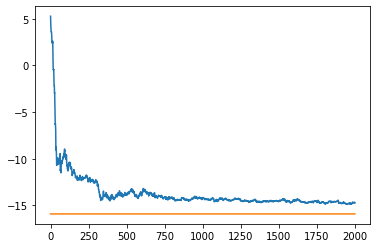

In [200]:
import matplotlib.pyplot as plt

E0 = [np.sort(e)[0] for i in range(len(result))]

El = [result[i]['E'] for i in range(len(result))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.plot(tl,E0)

### On Chip

In [18]:
def interim_result_callback(job_id, interim_result):
    print(f"interim result: {interim_result}")

In [19]:
backend = provider.get_backend('ibmq_bogota')
options = {'backend_name': backend.name()}
inputs = {"k_max": 3, "phi": phi, "alpha": alpha, "blocks":blocks}
job = provider.runtime.run(program_id, options=options, inputs=inputs, callback=interim_result_callback)

In [ ]:
print(f"job id: {job.job_id()}")
result = job.result()

job id: c5skrdbrrcfjv06gq9p0


In [ ]:
result[2]['E']